In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path
import warnings
from IPython.display import clear_output

# Get the parent directory and add it to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

warnings.filterwarnings("ignore")

from data_builder import TimeSeriesBuilder, read_trans, read_labels
from utils import read_data, set_seed
from models import Model
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from training import train, test
from tqdm import tqdm

In [6]:
# load transcripts and cell types
folder = '../../Xenium/BreastS1R1/'
save_path = folder + 'play/'
cell_types = read_labels(filename=folder + 'Cell_Barcode_Type_Matrices.xlsx', sheet='Xenium R1 Fig1-5 (supervised)')
gene_list = sorted([f[:-4] for f in os.listdir(folder+'MoleculesPerGene') if f.endswith('.csv')])
gene = 'FOXA1'
transcripts = read_trans(folder + 'MoleculesPerGene/' + gene + '.csv')
num_cells = transcripts['cell_id'].nunique()
# Build time series
tsb = TimeSeriesBuilder(transcripts, cell_types)
tsb.run(num_samples=int(num_cells/10), save_path=save_path, gene=gene)

Building cell dictionaries
Build cell feature vectors
Find spatial neighbors
Calculate random walk transition probabilities
Start building the dataset


100%|██████████| 10080/10080 [00:01<00:00, 6014.17it/s]


10080 time-series samples of FOXA1 generated


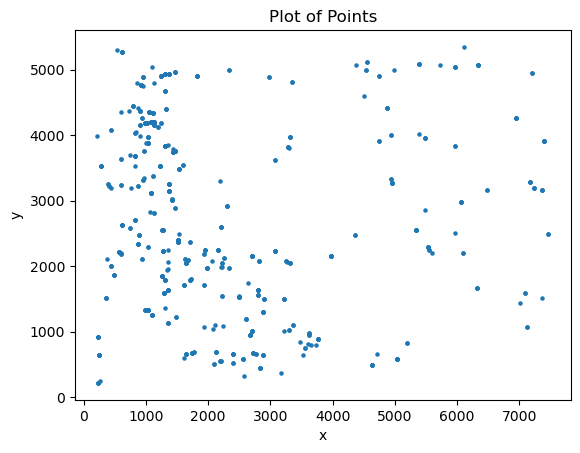

In [7]:
import pandas as pd

folder = '../../Xenium/BreastS1R1/'
save_path = folder + 'TimeSeries/'

locs = pd.read_csv(save_path + 'AVPR1A' + '_locs.csv')
import matplotlib.pyplot as plt

plt.scatter(locs.iloc[:, 0], locs.iloc[:, 1], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of Points')
plt.show()


In [9]:
tf = 'GATA3'
gene = 'FOXA1'

# Use tf as base gene, generate time-series samples for the regulated gene
base_gene = tf
refer_cell_ids = pd.read_csv(save_path + base_gene + '_ids.csv').values
transcripts = read_trans(folder+'MoleculesPerGene/' + gene + '.csv')
num_cells = transcripts['cell_id'].nunique()
tsb = TimeSeriesBuilder(transcripts, cell_types)
tsb.run(num_samples=int(num_cells/10), save_path=save_path+'pairs/', gene=gene, method='refer', reference_ids=refer_cell_ids)

Building cell dictionaries
Build cell feature vectors
10080 time-series samples of FOXA1 generated


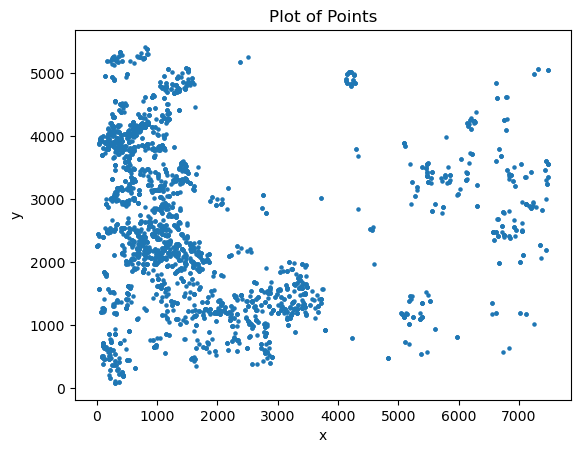

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

folder = '../../Xenium/BreastS1R1/'
tf = 'AR'
gene = 'CDH1'
tf_gene_folder = os.path.join(folder+'DelayPairs/', f"{tf}_{gene}/")

locs = pd.read_csv(tf_gene_folder + 'CDH1' + '_locs.csv')

plt.scatter(locs.iloc[:, 0], locs.iloc[:, 1], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of Points')
plt.show()


In [16]:
def easy_test(data_folder, model_folder, gene, SEQ_LEN, dim_inputs, hidden_size, latent_size):
    # load test data
    data_path = data_folder + gene + '_data.csv'
    locs_path = data_folder + gene + '_locs.csv'
    data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
    test_data = data
    test_locs = locs
    # load the trained model and start test
    model_path = model_folder + gene + '_model.pth'
    net = Model(dim_inputs, hidden_size, latent_size, SEQ_LEN)
    net.load_state_dict(torch.load(model_path))
    with torch.no_grad():
        prediction, generation, trans_status, loss_recon = test(test_data, test_locs, net)
    return prediction, generation, trans_status, loss_recon

In [17]:
import numpy as np
import gc
# Set parameters
SEQ_LEN = 20
dim_inputs = 10
hidden_size = 100
latent_size = 100

batch_size = 1024
base_lr = 0.01
lr_step = 10
num_epochs = 100

# Train on the regulated gene
gene = 'FOXA1'
data_path = save_path + 'pairs/' + gene + '_data.csv'
locs_path = save_path + 'pairs/' + gene + '_locs.csv'
data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
train_data = data
train_locs = locs
set_seed(42)
net, _, _ = train(train_data, train_locs, batch_size, base_lr, lr_step, num_epochs, hidden_size, latent_size, SEQ_LEN)
torch.save(net.state_dict(), save_path + 'pairs/' + gene + '_model.pth')
# Test on the regulated gene
_, generation, trans_status, _ = easy_test(save_path + 'pairs/', save_path + 'pairs/', gene, SEQ_LEN, dim_inputs, hidden_size, latent_size)

# Test on the saved model of the tf
data_folder_tf = folder + 'TimeSeries/'
model_folder_tf = folder + 'Models/'
_, generation_tf, trans_status_tf, _ = easy_test(data_folder_tf, model_folder_tf, tf, SEQ_LEN, dim_inputs, hidden_size, latent_size)

# Save the paired velos
reference = pd.read_csv(save_path + 'pairs/' + gene + '_reference.csv')
rows = []

# Loop through all indices in the reference dataframe
for i in range(len(reference)):
    # Extract reference index
    ref = int(reference.iloc[i])

    # Process generated and base data
    gen = generation[i].view(-1).cpu().detach().numpy()
    status = trans_status[i].view(-1).cpu().detach().numpy()
    gen_tf = generation_tf[ref].view(-1).cpu().detach().numpy()
    status_tf = trans_status_tf[ref].view(-1).cpu().detach().numpy()

    # Compute velo and velo_base
    velo = gen * status
    velo_tf = gen_tf * status_tf

    # Save the pair as a row
    rows.append(np.hstack((velo_tf, velo)))

# Convert rows to a DataFrame and save to a CSV file
output_df = pd.DataFrame(rows)
output_df.to_csv(save_path + 'pairs/' + f"{tf}_{gene}_velos.csv", index=False, header=False)
torch.cuda.empty_cache() 
gc.collect()

Training: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


0

In [19]:
velos = pd.read_csv(save_path + 'pairs/' + f"{tf}_{gene}_velos.csv", header=None)
velos

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,2.455504,2.747504,2.962743,3.039271,0.000000,3.033429,3.056286,0.000000,3.008008,3.039607,...,2.483680,2.480097,2.468512,2.464351,2.454299,2.440088,2.438360,2.435351,2.439701,2.428218
1,2.487890,2.614269,2.790244,2.861620,2.889785,2.899217,2.917415,2.927929,0.000000,0.000000,...,1.769578,1.764612,1.770510,1.778509,1.781439,1.778133,1.780483,1.783286,1.784696,1.785265
2,0.000000,2.285708,1.938890,1.785582,1.700188,1.611550,1.520979,1.453529,1.388079,1.337510,...,1.617867,1.623696,1.620181,1.613268,1.620730,1.631272,1.633706,1.632661,1.635797,1.640120
3,2.455504,2.960193,3.228692,3.343877,3.382196,3.385829,3.411306,3.408352,3.413219,3.417350,...,1.645366,1.648603,1.647434,1.647862,1.653689,1.658388,1.657856,1.657158,1.662871,1.670149
4,2.106589,2.121489,2.085382,2.075816,2.055438,2.052448,2.054945,2.054750,2.055038,2.062750,...,2.175100,2.189922,2.197022,2.202466,2.208765,2.213559,2.216335,2.208922,2.209933,2.208117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8669,2.119871,2.277910,2.365847,2.426254,2.431067,2.421012,2.408263,0.000000,0.000000,2.337207,...,1.671628,1.675243,1.673071,1.670929,1.678176,1.680066,1.679347,1.682370,1.682894,1.683603
8670,2.455504,2.470066,2.426537,2.404169,2.388172,2.390956,2.401860,2.404012,2.416897,2.421373,...,1.631037,1.634681,1.645993,1.647958,1.641949,1.644074,1.649364,1.653840,1.654796,1.655596
8671,2.106589,2.190499,2.229198,0.000000,0.000000,2.224368,2.208211,2.210628,2.207155,2.210251,...,1.699748,1.698774,1.688435,1.686545,1.687239,1.687676,1.690338,1.688765,1.690540,1.693765
8672,2.432946,2.341890,2.338729,2.331431,0.000000,0.000000,2.275120,2.272417,0.000000,2.256609,...,2.453039,2.451950,2.449305,2.453887,2.454792,2.446645,2.444533,2.437223,2.420965,2.410936


In [24]:
# Import Python libraries
# Examples tested with python v3.12.0, dask v2024.5.2
import dask.dataframe as dd

# Read in the parquet file, edit path to where parquet file saved
df = dd.read_parquet('/home/xiao/Projects/SpatialDynamics/Jing/output-XETG00126__0029719__0_hr__20241213__182319 (1)/transcripts.parquet')
# Print information about the data frame
df.info()
# Print first 5 rows of the dask data frame
df.head()

# Optional: convert parquet data frame to CSV, edit path and output name for new file
# dask automatically figures out chunk size and saves each as a CSV file in the directory path specified below
# df.to_csv('path/to/your/transcripts_csv_directory', index=False)


<class 'dask.dataframe.core.DataFrame'>
Columns: 13 entries, transcript_id to is_gene
dtypes: object(4), bool(1), float32(5), int32(1), uint64(1), uint8(1)

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
0,281474976720937,UNASSIGNED,0,APOL2,214.187500,147.625000,10.781250,28.75,U6,392.859375,419,custom_gene,True
1,281474976725723,UNASSIGNED,0,APOL6,12.546875,249.765625,11.046875,40.00,U6,448.281250,417,custom_gene,True
2,281474976725732,UNASSIGNED,0,APOL6,29.046875,195.437500,11.000000,40.00,U6,472.015625,417,custom_gene,True
3,281474976725733,UNASSIGNED,0,APOL6,32.375000,240.984375,11.109375,40.00,U6,439.156250,417,custom_gene,True
4,281474976725735,UNASSIGNED,0,APOL6,32.906250,186.015625,11.062500,40.00,U6,475.843750,417,custom_gene,True


In [27]:
df['feature_name'].compute()

0         APOL2
1         APOL6
2         APOL6
3         APOL6
4         APOL6
          ...  
718500    APOL6
718501    APOL6
718502      FST
718503     GBP1
718504     SOD2
Name: feature_name, Length: 718505, dtype: object

In [60]:
import os
import pandas as pd
folder = '../../Xenium/BreastS1R1/MoleculesPerGene/'
gene = 'AVPR1A'
trans = pd.read_csv(folder + gene + '.csv')
grouped_trans_sizes = trans.groupby('cell_id').size()
avg, med, maximum = grouped_trans_sizes.mean(), grouped_trans_sizes.median(), grouped_trans_sizes.max()
avg, med, maximum


(1.7852083676494812, 1.0, 22)